In [17]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras import backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
print(backend.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
df_full = pd.read_csv('Consumer_Complaints.csv')
df = df_full.dropna(subset = ["Consumer complaint narrative"])[["Product", "Consumer complaint narrative"]]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231441 entries, 0 to 231440
Data columns (total 2 columns):
Product                         231441 non-null object
Consumer complaint narrative    231441 non-null object
dtypes: object(2)
memory usage: 3.5+ MB


In [4]:
df.Product.value_counts()

Debt collection                                                                 53600
Mortgage                                                                        39452
Credit reporting                                                                31592
Credit reporting, credit repair services, or other personal consumer reports    29805
Credit card                                                                     18842
Bank account or service                                                         14888
Student loan                                                                    14687
Consumer Loan                                                                    9472
Credit card or prepaid card                                                      6197
Checking or savings account                                                      3836
Payday loan                                                                      1748
Vehicle loan or lease                                 

In [5]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

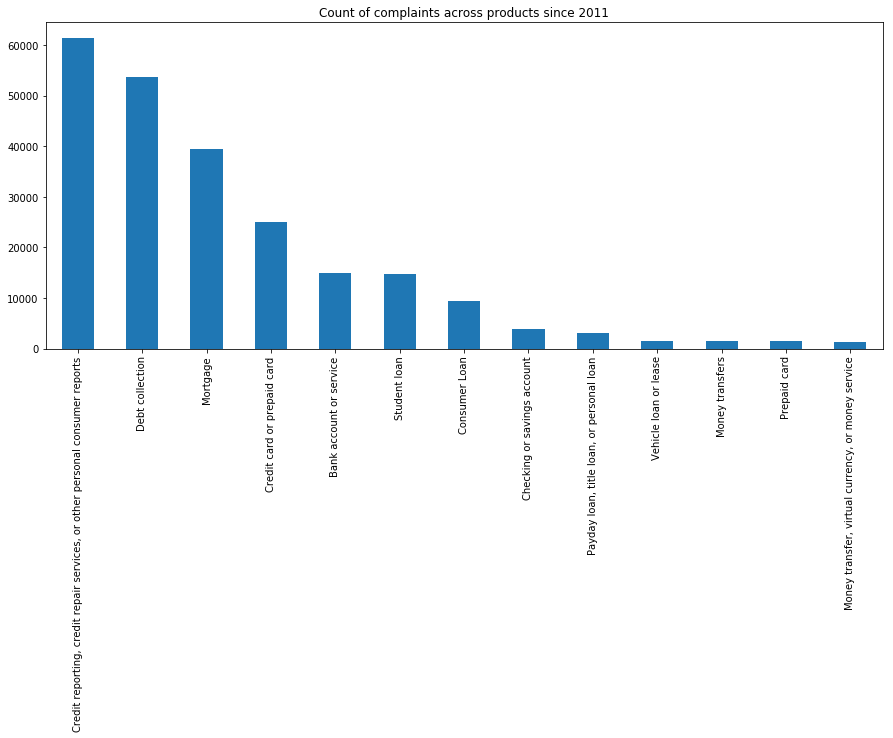

In [6]:
df["Product"].value_counts().plot(x='Product', y='Number of complaints', kind='bar', figsize=(15,6),\
                                  title='Count of complaints across products since 2011')

In [7]:
def print_plot(index):
    example = df[df.index == index][["Product", "Consumer complaint narrative"]].values[0]
    if len(example) > 0:
        print(example[1])
        print('Product:', example[0])

In [8]:
print_plot(10)

Without provocation, I received notice that my credit line was being decreased by nearly 100 %. My available credit was reduced from $ XXXX to XXXX ( the rough amount of my available balance ). 

When I called to question the change, I was provided a nob-descript response referencing my XXXX report. It was my understanding that under the FCRA I was entitled to a copy of this report, but was refused by Citi and have been given no further explanation. 

This is predatory in that it affects my utilization of credit, further subjecting me to increase in APrs, etc and a higher cost of credit without any reason.
Product: Credit card or prepaid card


In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. 
                                              # substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. 
                                        # substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [10]:
print_plot(10)

without provocation received notice credit line decreased nearly  available credit reduced rough amount available balance called question change provided nobdescript response referencing report understanding fcra entitled copy report refused citi given eplanation predatory affects utilization credit subjecting increase aprs etc higher cost credit without reason
Product: Credit card or prepaid card


In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108892 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (231148, 250)


In [13]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (231148, 13)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(208033, 250) (208033, 13)
(23115, 250) (23115, 13)


In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total para

In [19]:
epochs = 5
batch_size = 64

history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 187229 samples, validate on 20804 samples
Epoch 1/5
187229/187229 [==============================] - 1797s 10ms/step - loss: 0.9485 - acc: 0.7148 - val_loss: 0.6803 - val_acc: 0.7954
Epoch 2/5
187229/187229 [==============================] - 1775s 9ms/step - loss: 0.6389 - acc: 0.8066 - val_loss: 0.5697 - val_acc: 0.8216
Epoch 3/5
187229/187229 [==============================] - 1763s 9ms/step - loss: 0.5365 - acc: 0.8314 - val_loss: 0.5340 - val_acc: 0.8319
Epoch 4/5
187229/187229 [==============================] - 1766s 9ms/step - loss: 0.4818 - acc: 0.8470 - val_loss: 0.5156 - val_acc: 0.8366
Epoch 5/5
187229/187229 [==============================] - 1764s 9ms/step - loss: 0.4406 - acc: 0.8593 - val_loss: 0.5225 - val_acc: 0.8363


In [20]:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model.save(os.path.join(model_dir, 'LSTM.h5'))

In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

23115/23115 [==============================] - 150s 6ms/step
Test set
  Loss: 0.539
  Accuracy: 0.829


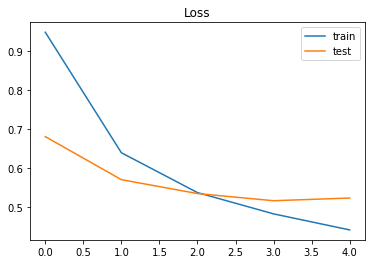

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

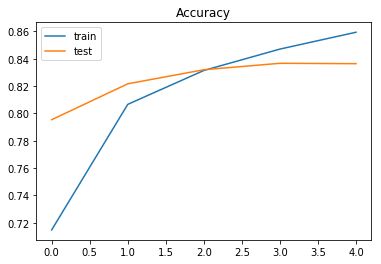

In [23]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [24]:
model = load_model(os.path.join(model_dir, 'LSTM.h5'))

In [25]:
predictions = model.predict(X_test)

In [26]:
classes = pd.get_dummies(df["Product"]).columns.values
matrix = confusion_matrix(Y_test.argmax(axis = 1), predictions.argmax(axis = 1))
report = classification_report(Y_test.argmax(axis = 1), predictions.argmax(axis = 1), target_names = classes)

/home/wenbo/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
print(matrix)
print(report)

[[1189    2   39   91   15   48    1   29   54    6   18    4    0]
 [ 358    0    4   12    7   10    2    6    4    3    0    2    0]
 [  16    0  627   36   80  126    0    0   32   46    0   14    0]
 [ 106    0   33 1874  157  210    0    2   20    1   22    3    0]
 [  33    0   75  101 5333  479    0    0   86    4    0   30    0]
 [  26    0   73   65  222 4823    0    3   88   24    0   64    0]
 [  37    0    1   17    4    2   50   43    3    1    1    3    0]
 [  23    0    0    6    2    4    4   81    2    1    2    0    0]
 [  22    0   29    9   59   78    1    0 3737    1    0    6    0]
 [  10    0   83    4   10   91    0    2   12  107    0    3    0]
 [  14    0    0   18    5    2    0    3    1    0   90    0    0]
 [   4    0   22    4   55   73    1    1   20    8    0 1253    0]
 [   1    0  129    3   11    4    0    0    4    0    0    0    0]]
                                                                              precision    recall  f1-score   suppo